In [1]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm
import pickle
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Mon Jun 27 14:34:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           On   | 00000000:07:00.0 Off |                  Off |
| 30%   31C    P2    71W / 300W |  40800MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  RTX A6000           On   | 00000000:11:00.0 Off |                  Off |
| 30%   

In [3]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

## CV0 Initial Condition

In [4]:
#export PYTHONPATH="$PYTHONPATH//home/george/CAMELS/library/build/lib"
# import sys
# sys.path.append('home/george/CAMELS/library/build/lib')
#import camels_library as cl
import readgadget
import numpy as np

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [5]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [03:20<00:00,  5.88s/it]


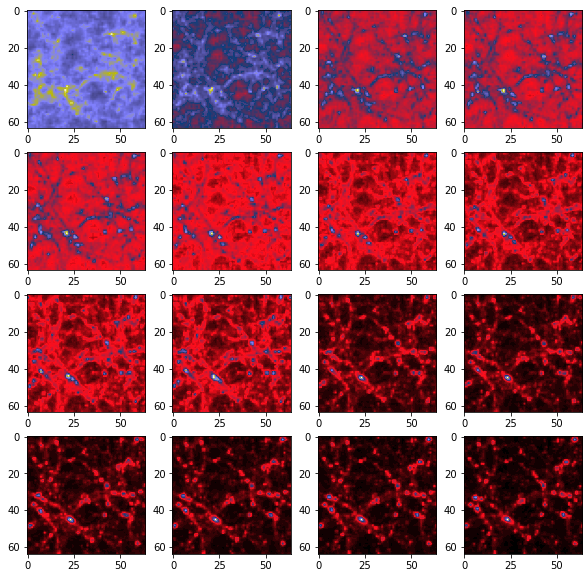

In [6]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

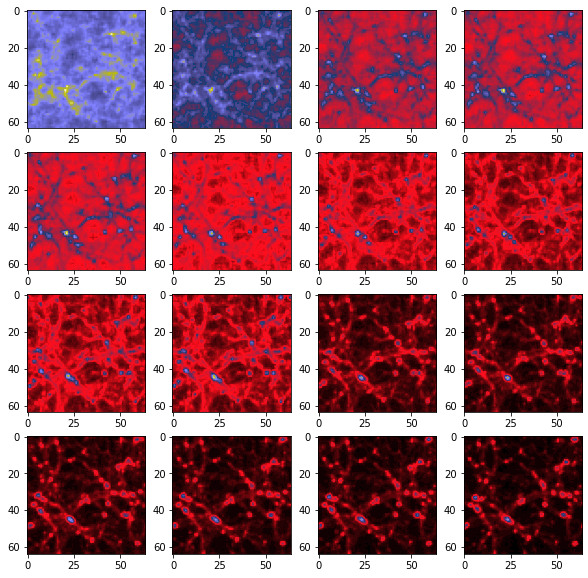

In [7]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

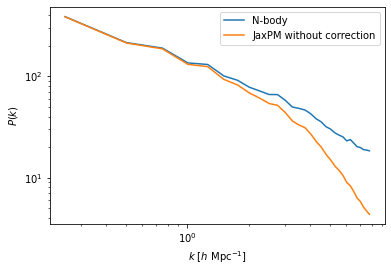

In [8]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)
      
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

## CV1 Initial Condition

In [9]:
import readgadget
import numpy as np

init_cond1 = 'CV_1/ICs/ics'

header   = readgadget.header(init_cond1)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i1 = np.argsort(readgadget.read_block(init_cond1, "ID  ", ptype)-1)  #IDs starting from 0
pos_i1 = readgadget.read_block(init_cond1, "POS ", ptype)[ids_i1]/1e3     #positions in Mpc/h
vel_i1 = readgadget.read_block(init_cond1, "VEL ", ptype)[ids_i1]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i1 = pos_i1.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i1 = vel_i1.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i1 = (pos_i1/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i1 = (vel_i1 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

In [10]:
scales1 = []
poss1 = []
vels1 = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot1='CV_1/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot1)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids1 = np.argsort(readgadget.read_block(snapshot1, "ID  ", ptype)-1)   #IDs starting from 0
    pos1 = readgadget.read_block(snapshot1, "POS ", ptype)[ids1]/1e3        #positions in Mpc/h
    vel1 = readgadget.read_block(snapshot1, "VEL ", ptype)[ids1]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos1 = pos1.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel1 = vel1.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos1 = (pos1 / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel1 = (vel1 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales1.append((1./(1+redshift)))
    poss1.append(pos1)
    vels1.append(vel1)

100%|██████████| 34/34 [03:49<00:00,  6.74s/it]


In [11]:
# Run the reference simulation without correction at the same steps
resi1 = odeint(make_ode_fn(mesh_shape), [poss1[0], vels1[0]], jnp.array(scales1), cosmo, rtol=1e-5, atol=1e-5)

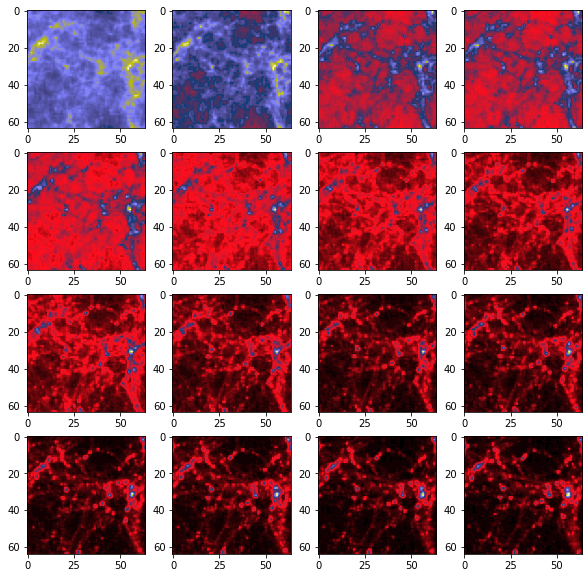

In [12]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss1[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

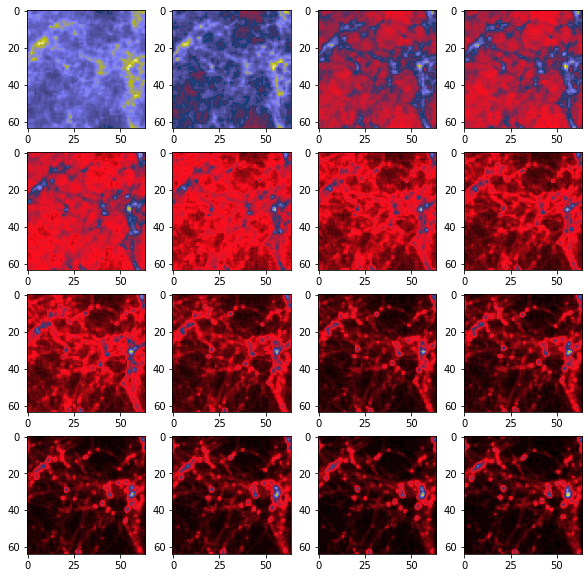

In [13]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi1[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss1[::2][i]).sum(axis=0).max(),vmin=0)

In [14]:
k1, pk_ref1 = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss1[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k1, pk_i1 = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi1[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

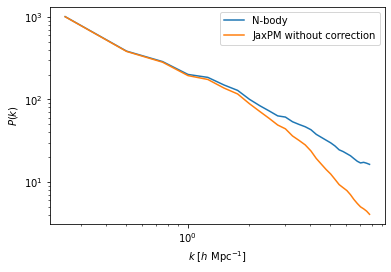

In [15]:
loglog(k1,pk_ref1, label='N-body')
loglog(k1,pk_i1, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

## CV2 Initial Condition

In [16]:
init_cond2 = 'CV_2/ICs/ics'

header   = readgadget.header(init_cond2)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i2 = np.argsort(readgadget.read_block(init_cond2, "ID  ", ptype)-1)  #IDs starting from 0
pos_i2 = readgadget.read_block(init_cond2, "POS ", ptype)[ids_i2]/1e3     #positions in Mpc/h
vel_i2 = readgadget.read_block(init_cond2, "VEL ", ptype)[ids_i2]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i2 = pos_i2.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i2 = vel_i2.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i2 = (pos_i2/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i2 = (vel_i2 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

scales2 = []
poss2 = []
vels2 = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot2='CV_2/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot2)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids2 = np.argsort(readgadget.read_block(snapshot2, "ID  ", ptype)-1)   #IDs starting from 0
    pos2 = readgadget.read_block(snapshot2, "POS ", ptype)[ids2]/1e3        #positions in Mpc/h
    vel2 = readgadget.read_block(snapshot2, "VEL ", ptype)[ids2]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos2 = pos2.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel2 = vel2.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos2 = (pos2 / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel2 = (vel2 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales2.append((1./(1+redshift)))
    poss2.append(pos2)
    vels2.append(vel2)

100%|██████████| 34/34 [03:57<00:00,  6.99s/it]


## CV3 Initial Condition

In [17]:
init_cond3 = 'CV_3/ICs/ics'

header   = readgadget.header(init_cond3)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i3 = np.argsort(readgadget.read_block(init_cond3, "ID  ", ptype)-1)  #IDs starting from 0
pos_i3 = readgadget.read_block(init_cond3, "POS ", ptype)[ids_i3]/1e3     #positions in Mpc/h
vel_i3 = readgadget.read_block(init_cond3, "VEL ", ptype)[ids_i3]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i3 = pos_i3.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i3 = vel_i3.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i3 = (pos_i3/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i3 = (vel_i3 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

scales3 = []
poss3 = []
vels3 = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot3='CV_3/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot3)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids3 = np.argsort(readgadget.read_block(snapshot3, "ID  ", ptype)-1)   #IDs starting from 0
    pos3 = readgadget.read_block(snapshot3, "POS ", ptype)[ids3]/1e3        #positions in Mpc/h
    vel3 = readgadget.read_block(snapshot3, "VEL ", ptype)[ids3]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos3 = pos3.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel3 = vel3.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos3 = (pos3 / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel3 = (vel3 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales3.append((1./(1+redshift)))
    poss3.append(pos3)
    vels3.append(vel3)

100%|██████████| 34/34 [03:59<00:00,  7.03s/it]


## CV4 Initial Condition

In [18]:
init_cond4 = 'CV_4/ICs/ics'

header   = readgadget.header(init_cond4)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i4 = np.argsort(readgadget.read_block(init_cond4, "ID  ", ptype)-1)  #IDs starting from 0
pos_i4 = readgadget.read_block(init_cond4, "POS ", ptype)[ids_i4]/1e3     #positions in Mpc/h
vel_i4 = readgadget.read_block(init_cond4, "VEL ", ptype)[ids_i4]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i4 = pos_i4.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i4 = vel_i4.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i4 = (pos_i4/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i4 = (vel_i4 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

scales4 = []
poss4 = []
vels4 = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot4='CV_4/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot4)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids4 = np.argsort(readgadget.read_block(snapshot4, "ID  ", ptype)-1)   #IDs starting from 0
    pos4 = readgadget.read_block(snapshot3, "POS ", ptype)[ids4]/1e3        #positions in Mpc/h
    vel4 = readgadget.read_block(snapshot3, "VEL ", ptype)[ids4]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos4 = pos4.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel4 = vel4.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos4 = (pos4 / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel4 = (vel4 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales4.append((1./(1+redshift)))
    poss4.append(pos4)
    vels4.append(vel4)

100%|██████████| 34/34 [02:43<00:00,  4.81s/it]


## CV5 Initial Condition

In [19]:
init_cond5 = 'CV_5/ICs/ics'

header   = readgadget.header(init_cond5)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i5 = np.argsort(readgadget.read_block(init_cond5, "ID  ", ptype)-1)  #IDs starting from 0
pos_i5 = readgadget.read_block(init_cond5, "POS ", ptype)[ids_i5]/1e3     #positions in Mpc/h
vel_i5 = readgadget.read_block(init_cond5, "VEL ", ptype)[ids_i5]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i5 = pos_i5.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i5 = vel_i5.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i5 = (pos_i5/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i5 = (vel_i5 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

scales5 = []
poss5 = []
vels5 = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot5='CV_5/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot5)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids5 = np.argsort(readgadget.read_block(snapshot5, "ID  ", ptype)-1)   #IDs starting from 0
    pos5 = readgadget.read_block(snapshot3, "POS ", ptype)[ids5]/1e3        #positions in Mpc/h
    vel5 = readgadget.read_block(snapshot3, "VEL ", ptype)[ids5]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos5 = pos5.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel5 = vel5.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos5 = (pos5 / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel5 = (vel5 / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales5.append((1./(1+redshift)))
    poss5.append(pos5)
    vels5.append(vel5)

100%|██████████| 34/34 [02:24<00:00,  4.24s/it]


In [20]:
print(Erorrr)

NameError: name 'Erorrr' is not defined

## Neural Network

In [21]:
# Instantiate the neural network
# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [22]:
import jax
import jax.numpy as jnp
import haiku as hk



class SpectralConv3(hk.Module):
  """Attempt"""

  def __init__(self, in_channels=1, out_channels=1, modes1=32, modes2=32, modes3=32, is_training=True, name='Layer'):

    super().__init__(name=name)
    self.name= name
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
    self.modes2 = modes2
    self.modes3 = modes3
    
    self.scale = (1 / (self.in_channels * self.out_channels))
    self.weights1= hk.get_parameter(str(self.name)+ "w1", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights2= hk.get_parameter(str(self.name)+ "w2", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights3= hk.get_parameter(str(self.name)+ "w3", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights4= hk.get_parameter(str(self.name)+ "w4", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())


  def __call__(self, pot_k):

    def compl_mul3d(input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return jnp.einsum("bixyz,ioxyz->boxyz", input, weights)
    
  
        
    self.weights1=self.weights1*self.scale
    self.weights2=self.weights2*self.scale
    self.weights3=self.weights3*self.scale
    self.weights4=self.weights4*self.scale

    batchsize=1
    
    
    #x_ft=x_ft.reshape(1,1,64,64,33)
    x_ft=pot_k
    
    _,_,dim1,dim2,dim3=x_ft.shape
    
    out_ft=jnp.zeros([batchsize, self.out_channels, dim1, dim2, dim3], dtype=float)
    out_ft=out_ft.at[:, :, :self.modes1, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1))

    out_ft=out_ft.at[:, :, -self.modes1:, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2))

    out_ft=out_ft.at[:, :, :self.modes1, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3))

    out_ft=out_ft.at[:, :, -self.modes1:, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4))

    

    return out_ft

In [23]:
class Outside(hk.Module):
    def __init__(self,width,modes1=8,modes2=8,modes3=8, padding=3,name="PaperNetwork"):
        
        super().__init__(name=name)
        self.modes1= modes1
        self.modes2= modes2
        self.modes3= modes3
        self.width = width
        self.padding=6
        self.conv0 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l0')
        self.conv1 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l1')
        self.conv2 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l2')
        self.conv3 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l3')
        self.w0 = hk.Conv3D(self.width, 1)
        self.w1 = hk.Conv3D(self.width,  1)
        self.w2 = hk.Conv3D(self.width,  1)
        self.w3 = hk.Conv3D(self.width,  1)
        self.w4 = hk.Conv3D(3,  1)
        
    def __call__(self,pot_k):

        start_p=int(self.padding)
        end_p=-start_p
        x=pot_k
        #print("Start",x.shape)
        dim1,dim2,dim3=x.shape
        x_skip=x

        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,jax.numpy.newaxis,...]
        x1 = self.conv0(x1)
        x1 = np.squeeze(x1, axis=0)
        x1 = jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        
        

        x = jax.numpy.pad(x, ((self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x = x[...,jax.numpy.newaxis]
        x2 = self.w0(x)
        x2 = jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]


        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)

        x_skip=x

        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv1(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w1(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)

        x_skip=x
        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv2(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w2(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)
        
        x_skip=x
        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv3(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w3(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)        
        #Final Convolution

        x=jax.numpy.transpose(x, (1,2,3,0))
        x = self.w4(x)
        print(x.shape)


        return x
        

model = hk.without_apply_rng(hk.transform(lambda x : Outside(width=10,modes1=32,modes2=32,modes3=32)(x)))

params = model.init(next(rng_seq),jnp.ones((64,64,64)))

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/ops/scatter.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
(64, 64, 64, 3)


In [24]:

def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    #Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # # Apply a correction filter
    # kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    
    #pot_k = pot_k*0.99 + model.apply(params, pot_k)
    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces =   jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) for i in range(3)],axis=-1)
    #global saved
    modelx=model.apply(params, delta)
   
        
    forcesML=jnp.stack([cic_read(modelx[...,i],pos) for i in range(3)],axis=-1)

    # forces=  model.apply(params, delta) # +forces
    forces= forces+ forcesML
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [25]:
import collections
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pos1 = jnp.stack(poss1, axis=0)
ref_vel1 = jnp.stack(vels1, axis=0)
ref_pos2 = jnp.stack(poss2, axis=0)
ref_vel2 = jnp.stack(vels2, axis=0)
ref_pos3 = jnp.stack(poss3, axis=0)
ref_vel3 = jnp.stack(vels3, axis=0)
ref_pos4 = jnp.stack(poss4, axis=0)
ref_vel4 = jnp.stack(vels4, axis=0)
ref_pos5 = jnp.stack(poss5, axis=0)
ref_vel5 = jnp.stack(vels5, axis=0)


@jax.jit
def testloss_fn(params,possX,velsX,scalesX,ref_posX,ref_velX):
  def calc(params,possX,velsX,scalesX,ref_posX,ref_velX):
    res = odeint(neural_nbody_ode, [possX[0], velsX[0]], jnp.array(scalesX), cosmo, params, rtol=1e-5, atol=1e-5)
    distance = jnp.sum((res[0] - ref_posX)**2, axis=-1)
    w = jnp.where(distance < 100, distance, 0.)
    # Optional lines to include velocity in the loss
    vel = jnp.sum((res[1] - ref_velX)**2, axis=-1)
    wv = jnp.where(distance < 100, vel, 0.)
    return wv,w
  
  wv,w=calc(params,poss1,vels1,scales1,ref_pos1,ref_vel1)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def loss_fn(params,possX,velsX,scalesX,ref_posX,ref_velX):
  def calc(params,possX,velsX,scalesX,ref_posX,ref_velX):
    res = odeint(neural_nbody_ode, [possX[0], velsX[0]], jnp.array(scalesX), cosmo, params, rtol=1e-5, atol=1e-5)
    distance = jnp.sum((res[0] - ref_posX)**2, axis=-1)
    w = jnp.where(distance < 100, distance, 0.)
    # Optional lines to include velocity in the loss
    vel = jnp.sum((res[1] - ref_velX)**2, axis=-1)
    wv = jnp.where(distance < 100, vel, 0.)
    return wv,w


  wv,w=calc(params,poss,vels,scales,ref_pos,ref_vel)
  wv2,w2=calc(params,poss2,vels2,scales2,ref_pos2,ref_vel2)
  wv3,w3=calc(params,poss3,vels3,scales3,ref_pos3,ref_vel3)
  wv4,w4=calc(params,poss4,vels4,scales4,ref_pos4,ref_vel4)
  wv5,w5=calc(params,poss5,vels5,scales5,ref_pos5,ref_vel5)

  return 0.01*jnp.mean(wv) + jnp.mean(w) + 0.01*jnp.mean(wv2) + jnp.mean(w2) + 0.01*jnp.mean(wv3) + jnp.mean(w3) + 0.01*jnp.mean(wv4) + jnp.mean(w4) + 0.01*jnp.mean(wv5) + jnp.mean(w5) 

  
  # return jnp.mean(w) + jnp.mean(jnp.sum((pk/ref_pk -1)**2,axis=-1))
@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params,poss,vels,scales,ref_pos,ref_vel)

    #grads= grads + grads2 + grads3 + grads4 + grads5

    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    test_loss, grads1 = jax.value_and_grad(testloss_fn)(params,poss1,vels1,scales1,ref_pos1,ref_vel1)
    return loss, new_params, new_opt_state,test_loss

In [26]:
losses = []
test_losses=[]

In [27]:

import optax
lr_fun= optax.cosine_decay_schedule(0.5, 1000 , alpha=0.0)
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [28]:
for step in tqdm(range(10000)):
  l, params, opt_state,test_loss = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l/5 ,"Test_loss: ", test_loss)
  losses.append(l/5)
  test_losses.append(test_loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
(64, 64, 64, 3)


2022-06-27 15:11:06.114574: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] Constant folding an instruction is taking > 1s:

  %negate.393 = f32[34,262144,3]{2,1,0} negate(f32[34,262144,3]{2,1,0} %constant.288)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-06-27 15:14:00.443214: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_update.135
********************************
  0%|          |

Step:  0  Loss:  6.4841514 Test_loss:  10.724844


  0%|          | 11/10000 [1:20:10<1417:05:06, 510.71s/it]

Step:  10  Loss:  0.00018270314 Test_loss:  0.0


  0%|          | 11/10000 [1:30:15<1366:07:52, 492.35s/it]


KeyboardInterrupt: 

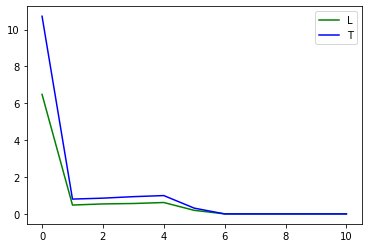

In [29]:
skip_loss=0
plt.plot(range(0,len(losses)-skip_loss), losses[skip_loss:], 'g', label='Label 1')
plt.plot(range(0,len(test_losses)-skip_loss), test_losses[skip_loss:] , 'b', label='Label 2')
legend('LT')

In [ ]:
losses[-1]

DeviceArray(0., dtype=float32)

In [37]:
res = odeint(neural_nbody_ode, [poss1[0], vels1[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

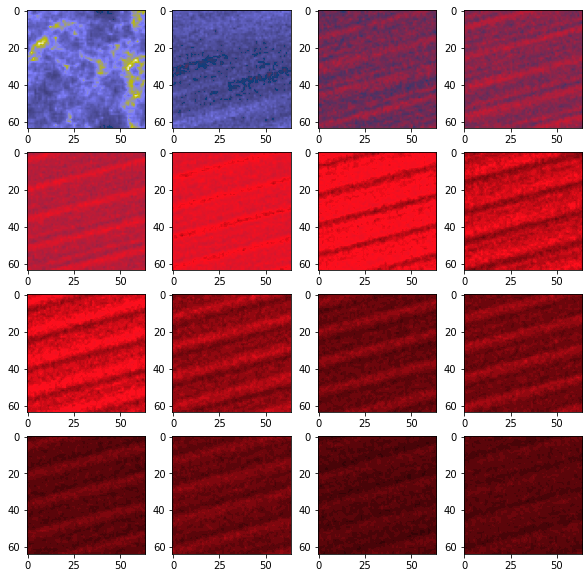

In [38]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss1[::2][i]).sum(axis=0).max(),vmin=0)

In [39]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss1[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi1[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

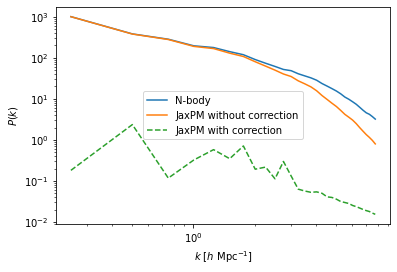

In [40]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

In [ ]:
import pickle
pickle.dump( params, open( "DL_20_970steps_05lr.params", "wb" ) )

In [ ]:
pos, vel = poss[0], vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint(jnp.zeros(mesh_shape), pos)

delta_k = jnp.fft.rfftn(delta)

# Computes gravitational potential
pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
#print(pot_k.shape)
# Apply a correction filter
kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
#print(model.apply(params, kk, jnp.atleast_1d(a)))
# Computes gravitational forces
forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                    for i in range(3)],axis=-1)

forces = forces * 1.5 * cosmo.Omega_m

# Computes the update of position (drift)
dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

# Computes the update of velocity (kick)
dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

In [ ]:
x2=(model.apply(params, kk, jnp.atleast_1d(a)))
x2.shape

In [ ]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

In [ ]:
len(res[0])

In [ ]:
f = lambda x,a : NeuralSplineFourierFilter()(x,a)
x = jnp.ones([8, 28 * 28])
for i in hk.experimental.eval_summary(f)(x,a):
  print("mod := {:14} | in := {} out := {}".format(
      i.module_details.module.module_name, i.args_spec[0], i.output_spec))

In [ ]:
x = jnp.ones([8, 28 * 28])
f = hk.transform(NeuralSplineFourierFilter)
print(hk.experimental.tabulate(f)(kk))

In [ ]:

class SpectralConv(hk.Module):
  """Attempt"""

  def __init__(self, in_channels=1, out_channels=1, modes1=32, modes2=32, modes3=32, is_training=True, name=None):

    super().__init__(name=name)
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
    self.modes2 = modes2
    self.modes3 = modes3
    
    self.scale = (1 / (self.in_channels * self.out_channels))
#     self.weights1= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights2= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights3= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights4= None # hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)


  def __call__(self, pot_k):

    def compl_mul3d(input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return jnp.einsum("bixyz,ioxyz->boxyz", input, weights)
    
    def main_fun(x_ft,in_channelsX,out_channelsX):
        weights1=hk.get_parameter("w1"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights2=hk.get_parameter("w2"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights3=hk.get_parameter("w3"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights4=hk.get_parameter("w4"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights1=weights1*self.scale
        weights2=weights2*self.scale
        weights3=weights3*self.scale
        weights4=weights4*self.scale


        batchsize=1
        out_ft=jnp.zeros([batchsize, out_channelsX, 64, 64, 33], dtype=float)

        out_ft=out_ft.at[:, :, :self.modes1, :self.modes2, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], weights1))

        out_ft=out_ft.at[:, :, -self.modes1:, :self.modes2, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], weights2))

        out_ft=out_ft.at[:, :, :self.modes1, -self.modes2:, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], weights3))

        out_ft=out_ft.at[:, :, -self.modes1:, -self.modes2:, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], weights4))

        return out_ft
    
    
    x_ft=pot_k
    x_ft=x_ft.reshape(1,1,64,64,33)

    out_ft=main_fun(x_ft,1,1)
    #out_ft=main_fun(out_ft,3,1)
    
    #out_ft=out_ft.reshape(64,64,33)
    return out_ft.reshape(64,64,33)

In [ ]:
import pickle
with (open("FullDeepRes10_05lr_Cor.params", "rb")) as openfile:
    while True:
        try:
            paramsLoad=pickle.load(openfile)
        except EOFError:
            break

In [ ]:

pos, vel = poss[0],vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint(jnp.zeros(mesh_shape), pos)

delta_k = jnp.fft.rfftn(delta)

#Computes gravitational potential
pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)

# # Apply a correction filter

# Computes gravitational forces
forces =   jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) for i in range(3)],axis=-1)
#global saved
modelx=model.apply(paramsLoad, delta)
# print(modelx.shape)
# neural_nbody_ode.savedx= jax.numpy.copy(modelx)
# print(neural_nbody_ode.savedx)
# import dill as dill
# with open('modelxArr.txt', 'wb') as f:
#     dill.dump(modelx, f)
# jax.numpy.savetx("modelxArr",modelx)
    
forcesML=jnp.stack([cic_read(modelx[...,i],pos) for i in range(3)],axis=-1)

# forces=  model.apply(params, delta) # +forces
forces= forces+ forcesML
forces = forces * 1.5 * cosmo.Omega_m



In [ ]:
data=modelx
print(data.shape)
#data=numpy.array(data)
dim1,dim2,dim3,dim4=data.shape

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

sp = ax.scatter(data[:,0],data[:,1],data[:,2], s=20, c=data[:,3])
plt.colorbar(sp)

In [ ]:
imgs=[]
minus=60

for i in range(dim1-minus):
    for j in range(dim4):
        imgs.append(data[i,:,:,j])


_, axs = plt.subplots(dim1-minus, dim4, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
imgs=[]
minus=50

for i in range(dim1-minus):
    for j in range(dim4):
        imgs.append(data[i,:,:,j])


_, axs = plt.subplots(dim1-minus, dim4, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
import pickle
pickle.dump( params, open( "FullDeepRes10_05lr_Cor.params", "wb" ) )

In [ ]:
import jax
import jax.numpy as jnp
import jax.lax as lax

from jaxpm.kernels import fftk, cic_compensation

def cic_paint_vel(mesh, positions,weight=None):
  """ Paints positions onto mesh
  mesh: [nx, ny, nz]
  positions: [npart, 3]
  """
  positions = jnp.expand_dims(positions, 1)
  floor = jnp.floor(positions)
  connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], 
                           [0., 0, 1], [1., 1, 0], [1., 0, 1], 
                           [0., 1, 1], [1., 1, 1]]])

  neighboor_coords = floor + connection
  kernel = 1. - jnp.abs(positions - neighboor_coords)
  kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]  

  if weight is not None:
      kernel = jax.numpy.multiply(jax.numpy.expand_dims(weight, axis=-1), kernel)

  neighboor_coords = jnp.mod(neighboor_coords.reshape([-1,8,3]).astype('int32'), jnp.array(mesh.shape))

  dnums = jax.lax.ScatterDimensionNumbers(
    update_window_dims=(),
    inserted_window_dims=(0, 1, 2),
    scatter_dims_to_operand_dims=(0, 1, 2))
  mesh = lax.scatter_add(mesh, 
                         neighboor_coords, 
                         kernel.reshape([-1,8]),
                         dnums)
  return mesh

In [ ]:
pos, vel = poss[0], vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint_vel(jnp.zeros(mesh_shape), pos, vel)


In [ ]:
import collections
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pos1 = jnp.stack(poss1, axis=0)
ref_vel1 = jnp.stack(vels1, axis=0)
ref_pos2 = jnp.stack(poss2, axis=0)
ref_vel2 = jnp.stack(vels2, axis=0)
ref_pos3 = jnp.stack(poss3, axis=0)
ref_vel3 = jnp.stack(vels3, axis=0)
ref_pos4 = jnp.stack(poss4, axis=0)
ref_vel4 = jnp.stack(vels4, axis=0)
ref_pos5 = jnp.stack(poss5, axis=0)
ref_vel5 = jnp.stack(vels5, axis=0)

@jax.jit
def loss_fn(params,possX,velsX,scalesX,ref_posX,ref_velX):
  res = odeint(neural_nbody_ode, [possX[0], velsX[0]], jnp.array(scalesX), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_posX)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_velX)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

  
  # return jnp.mean(w) + jnp.mean(jnp.sum((pk/ref_pk -1)**2,axis=-1))
@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params,poss,vels,scales,ref_pos,ref_vel)
    loss2, grads2 = jax.value_and_grad(loss_fn)(params,poss2,vels2,scales2,ref_pos2,ref_vel2)
    loss3, grads3 = jax.value_and_grad(loss_fn)(params,poss3,vels3,scales3,ref_pos3,ref_vel3)
    loss4, grads4 = jax.value_and_grad(loss_fn)(params,poss4,vels4,scales4,ref_pos4,ref_vel4)
    loss5, grads5 = jax.value_and_grad(loss_fn)(params,poss5,vels5,scales5,ref_pos5,ref_vel5)
    print(grads)
    a_counter = collections.Counter(grads)
    b_counter = collections.Counter(grads2)
    c_counter = collections.Counter(grads3)
    d_counter = collections.Counter(grads4)
    e_counter = collections.Counter(grads5)
    add_dict = a_counter + b_counter # + c_counter + d_counter + e_counter
    grads= dict(add_dict)

    #grads= grads + grads2 + grads3 + grads4 + grads5
    loss=(loss+ loss2 + loss3 + loss4 +loss5)/5

    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    test_loss, grads1 = jax.value_and_grad(loss_fn)(params,poss1,vels1,scales1,ref_pos1,ref_vel1)
    return loss, new_params, new_opt_state,test_loss